In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
labels_per_class = 'full' # full

### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_MNIST, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Network architecture

In [8]:
dims = (28,28,1)
n_components= 2

In [9]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

### Test model with just UMAP

In [10]:
from tfumap.semisupervised import find_a_b
from tfumap.umap import convert_distance_to_probability

In [11]:
min_dist = 0.001
_a, _b = find_a_b(min_dist)
_a, _b 

(<tf.Tensor: shape=(), dtype=float32, numpy=1.9290735>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.79150456>)

##### build iterator

In [12]:
from tfumap.semisupervised import build_fuzzy_simplicial_set
from tfumap.umap import compute_cross_entropy, get_graph_elements

In [13]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    #y=Y_masked,
    n_neighbors=n_neighbors,
)

In [14]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 60000])
batch_size

50000

### initialize embedding

In [15]:
from umap.spectral import spectral_layout
from sklearn.utils import check_random_state
random_state = check_random_state(None)
metric = "euclidean"
_metric_kwds = {}


def init_embedding_from_graph(
    _raw_data, graph, n_components, random_state, metric, _metric_kwds, init="spectral"
):
    """ Initialize embedding using graph. This is for direct embeddings. 

        Parameters
        ----------
        init : str, optional
            Type of initialization to use. Either random, or spectral, by default "spectral"

        Returns
        -------
        embedding : np.array
            the initialized embedding
        """
    if isinstance(init, str) and init == "random":
        embedding = random_state.uniform(
            low=-10.0, high=10.0, size=(graph.shape[0], n_components)
        ).astype(np.float32)
    elif isinstance(init, str) and init == "spectral":
        # We add a little noise to avoid local minima for optimization to come

        initialisation = spectral_layout(
            _raw_data,
            graph,
            n_components,
            random_state,
            metric=metric,
            metric_kwds=_metric_kwds,
        )
        expansion = 10.0 / np.abs(initialisation).max()
        embedding = (initialisation * expansion).astype(
            np.float32
        ) + random_state.normal(
            scale=0.0001, size=[graph.shape[0], n_components]
        ).astype(
            np.float32
        )

    else:
        init_data = np.array(init)
        if len(init_data.shape) == 2:
            if np.unique(init_data, axis=0).shape[0] < init_data.shape[0]:
                tree = KDTree(init_data)
                dist, ind = tree.query(init_data, k=2)
                nndist = np.mean(dist[:, 1])
                embedding = init_data + random_state.normal(
                    scale=0.001 * nndist, size=init_data.shape
                ).astype(np.float32)
            else:
                embedding = init_data

    return embedding

In [16]:
init_embedding = init_embedding_from_graph(X_train, graph, n_components, random_state, metric, _metric_kwds, init="spectral")

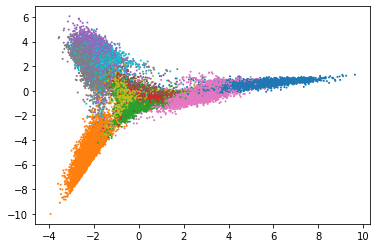

In [17]:
plt.scatter(init_embedding[:,0], init_embedding[:,1], c=Y_train, s=1, cmap=plt.cm.tab10)

In [125]:
def make_gen_callable(head, tail, edge_weights):
    def edge_generator():
        while True:
            yield (tf.expand_dims(head,-1), tf.expand_dims(tail,-1), edge_weights), [0]

    return edge_generator
edge_weights = tf.constant(weight)
edge_ds = tf.data.Dataset.from_generator( make_gen_callable(head, tail, edge_weights), ((tf.int32, tf.int32, tf.float32), tf.int32))
for (hd, tl, ew), _ in tqdm(edge_ds):
    break

In [173]:
batch_size = len(head)

In [174]:
negative_sample_rate = 5
repulsion_strength = 1.0

In [175]:
n_data = len(X_train)
embedding_layer = tf.keras.layers.Embedding(n_data, n_components, input_length=1)
embedding_layer.build(input_shape=(1,)) # the input_shape here has no effect in the build function
embedding_layer.set_weights([init_embedding])
encoder = tf.keras.Sequential([embedding_layer])

In [176]:
batch_head = tf.keras.Input(shape=(1), dtype=tf.int32, name = "head")
batch_tail = tf.keras.Input(shape=(1), dtype=tf.int32, name = "tail")
batch_weights = tf.keras.Input(shape=(1), dtype=tf.float32, name = "weights")


In [177]:
embedding_to = encoder(batch_head)[:,-1,:]
embedding_from = encoder(batch_tail)[:,-1,:]

In [178]:
embedding_from

<tf.Tensor 'strided_slice_48:0' shape=(None, 2) dtype=float32>

In [179]:
embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
embedding_neg_from = tf.gather(
    repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
)

In [180]:
#  distances between samples (and negative samples)
distance_embedding = tf.concat(
[
    tf.norm(embedding_to - embedding_from, axis=1),
    tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
],
axis=0,
)

In [181]:
# convert probabilities to distances
probabilities_distance = convert_distance_to_probability(
    distance_embedding, _a, _b
)

# set true probabilities based on negative sampling
probabilities_graph = tf.concat(
    [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
    axis=0,
)

In [182]:
EPS=1e-4

In [183]:
# cross entropy
attraction_term = -probabilities_graph * tf.math.log(
    tf.clip_by_value(probabilities_distance, EPS, 1.0)
)

In [184]:
repellant_term = (
    -(1.0 - probabilities_graph)
    * tf.math.log(tf.clip_by_value(1.0 - probabilities_distance, EPS, 1.0))
    * repulsion_strength
)

In [185]:
ce_loss = attraction_term + repellant_term

In [191]:
ce_loss

<tf.Tensor 'AddV2_18:0' shape=(6177648,) dtype=float32>

In [186]:
#ce = tf.keras.losses.binary_crossentropy(probabilities_graph, probabilities_distance)

In [187]:
model = tf.keras.Model(
    inputs=[batch_head, batch_tail, batch_weights],
    outputs=[ce_loss],
)

In [188]:
opt = tf.keras.optimizers.Adadelta(50)

In [189]:
model.compile(
    optimizer=opt,
    loss='mae',
)

In [190]:
history = model.fit(
    edge_ds,
    epochs=5,
    max_queue_size = 5,
)

Epoch 1/5
     88/Unknown - 14s 163ms/step - loss: 0.2833

KeyboardInterrupt: 

In [195]:
class CustomModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            print( 'y', y, 'y_pred', y_pred)
            loss = tf.reduce_mean(tf.math.abs(y_pred))

            # Compute gradients
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            #gradients = [tf.clip_by_value(grad, -4.0, 4.0) * alpha for grad in gradients] 

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
model = CustomModel(
    inputs=[batch_head, batch_tail, batch_weights],
    outputs=[ce_loss],
)

opt = tf.keras.optimizers.Adadelta(50)

model.compile(
    optimizer=opt,
    loss='mae',
)

history = model.fit(
    edge_ds,
    epochs=5,
    max_queue_size = 5,
)

Epoch 1/5
y Tensor("IteratorGetNext:3", dtype=int32) y_pred Tensor("custom_model_2/tf_op_layer_AddV2_18/AddV2_18:0", shape=(6177648,), dtype=float32)
y Tensor("IteratorGetNext:3", dtype=int32) y_pred Tensor("custom_model_2/tf_op_layer_AddV2_18/AddV2_18:0", shape=(6177648,), dtype=float32)
   1014/Unknown - 169s 167ms/step - loss: 0.2558

KeyboardInterrupt: 

In [343]:
def umap_loss(batch_size, negative_sample_rate, _a, _b, repulsion_strength = 1.0):
    @tf.function
    def loss(placeholder_y, embed_to_from):
        # split out to/from
        embedding_to, embedding_from = tf.split(embed_to_from, num_or_size_splits=2, axis=1)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
                
        # compute cross entropy
        if True:
            (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
                probabilities_graph,
                probabilities_distance,
                repulsion_strength=repulsion_strength,
            )
        else:
            ce_loss = tf.keras.losses.binary_crossentropy(probabilities_graph, probabilities_distance)
        #ce_loss = ce_loss * alpha
        #return tf.reduce_mean(ce_loss)
        return ce_loss

    return loss

In [351]:
class parametricUMAP(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        n_data,
        init_embedding,
        head,
        tail,
        edge_weights,
        _a,
        _b,
        n_components=2,
        negative_sample_rate=5,
        repulsion_strength=1.0,
        
        name="parametric_umap",
        **kwargs
    ):
        super(parametricUMAP, self).__init__(name=name, **kwargs)

        # build embedding layer
        embedding_layer = tf.keras.layers.Embedding(
            n_data, n_components, input_length=1
        )
        embedding_layer.build(input_shape=(1,))
        embedding_layer.set_weights([init_embedding])
        self.encoder = tf.keras.Sequential([embedding_layer])

        self.negative_sample_rate = negative_sample_rate
        self.repulsion_strength = repulsion_strength
        self.head = head
        self.tail = tail
        self.weight_tile = tf.tile(edge_weights, [negative_sample_rate + 1])
        self._a = _a
        self._b = _b

    def call(self, inputs):
        
        head, tail = inputs
        
        embedding_to = encoder(head)[:, -1, :]
        embedding_from = encoder(tail)[:, -1, :]
        embedding_to_from = tf.keras.layers.concatenate([embedding_to, embedding_from],axis=1)

        return embedding_to_from
        """# get negative samples
        embedding_neg_to = tf.repeat(embedding_to, self.negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, self.negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        # distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=(1,2)),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=(1,2)),
            ],
            axis=0,
        )
        
        # convert probabilities to distances
        probabilities_distance = 1.0 / (1.0 + self._a * distance_embedding ** (2 * self._b))

        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * self.negative_sample_rate)],
            axis=0,
        )

        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )
        ce_loss = ce_loss * self.weight_tile

        return ce_loss"""
    
    """ def train_step(self, data):
    # Unpack the data. Its structure depends on your model and
    # on what you pass to `fit()`.
    x, y = data
    print(x)
    with tf.GradientTape() as tape:
        y_pred = self(x, training=True)  # Forward pass
        # Compute the loss value
        # (the loss function is configured in `compile()`)
        loss = self.compiled_loss(0, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        #gradients = [tf.clip_by_value(grad, -4.0, 4.0) * alpha for grad in gradients] 

    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    # Update metrics (includes the metric that tracks the loss)
    self.compiled_metrics.update_state(y, y_pred)
    # Return a dict mapping metric names to current value
    return {m.name: m.result() for m in self.metrics}"""

In [352]:
n_data = len(X_train)

In [353]:
model = parametricUMAP(
    n_data=n_data,
    init_embedding=init_embedding,
    head=head,
    tail=tail,
    edge_weights=edge_weights,
    _a = _a,
    _b = _b
)

In [354]:
model.compile(
    optimizer=tf.keras.optimizers.Adadelta(50),
    loss=umap_loss(batch_size, negative_sample_rate, _a, _b, repulsion_strength=1.0),
)

In [355]:
def make_gen_callable(head, tail):
    def edge_generator():
        while True:
            yield (tf.expand_dims(head,-1), tf.expand_dims(tail,-1)), [0]

    return edge_generator
edge_weights = tf.constant(weight)
edge_ds = tf.data.Dataset.from_generator( make_gen_callable(head, tail), ((tf.int32, tf.int32), tf.int32))
for (hd, tl), _ in tqdm(edge_ds):
    break

In [356]:
edge_ds

<FlatMapDataset shapes: ((<unknown>, <unknown>), <unknown>), types: ((tf.int32, tf.int32), tf.int32)>

In [357]:
model.fit(edge_ds)

ValueError: in user code:

    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:757 train_step
        self.trainable_variables)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:2737 _minimize
        trainable_variables))
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:562 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1271 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['embeddings:0'].
